# Simple Vortex Model
This model uses pressure field as boundary condition and builds velocity using geostrophic balance equation. 

\begin{equation*}
u = -\frac{1}{f\rho} \frac{\partial P}{\partial y} \\\
v = +\frac{1}{f\rho} \frac{\partial P}{\partial x} \\\
\end{equation*}

The pressure field forms as 2D Gaussian. Coriolis parameter ($f$) and density ($\rho$) are constant. Everything is static and horizontally flat (2D).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

Grid settings

In [3]:
N = 120
x_start, x_end = -2.0, 2.0
y_start, y_end = -2.0, 2.0

x = np.linspace(x_start, x_end, N)
y = np.linspace(y_start, y_end, N)

X, Y = np.meshgrid(x, y)

Initial pressure settings. Using 2D Gussian destribution to form the pressure field. And making it as depression in Pa. 

In [4]:
# initial pressure settings
variance = 0.3    # radius
center = [ 0, 0 ] # location
alpha = 1000.     # amplitude of 

pos = np.dstack((X, Y))
p = 101500. - alpha*st.multivariate_normal.pdf(pos, mean=center, cov=np.eye(2) * variance)

Plot the pressure

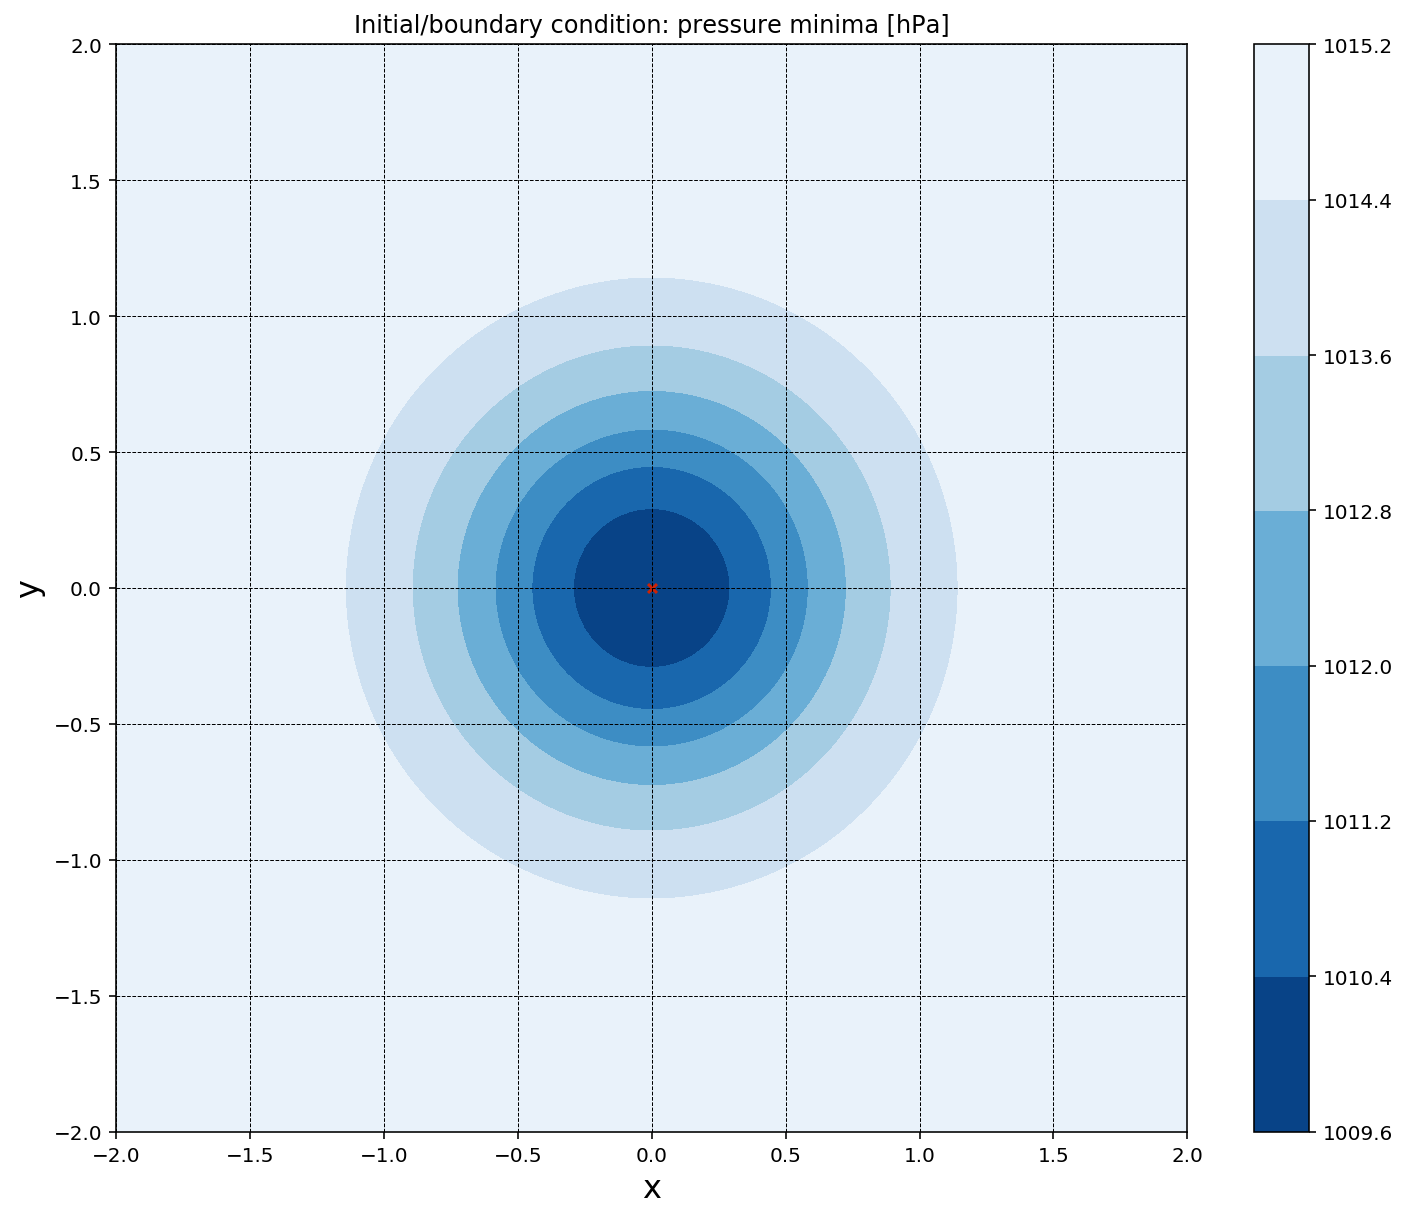

In [5]:
size=12

fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.grid(color='black', linestyle='--', linewidth=0.5)

plt.title("Initial/boundary condition: pressure minima [hPa]")

plt.contourf(X, Y, p/100, cmap='Blues_r')
plt.colorbar()
# plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
plt.show()

Compute the velocity using geostropic balance equation...

In [6]:
f = 10**-4 # midlats 
rho = 1.   # density is constant

# Disturbing the vortex with
# ubg = np.linspace(0.0, 5.0, num=N) # Couette flow at the backgroung
ubg = np.full(N, 2) # ... or flat flow 

dpdx = np.gradient(p, 20000, axis=1) # 1 is row in python
dpdy = np.gradient(p, 20000, axis=0) # 0 is column in python

u = -1./(f*rho)*dpdy + ubg[:, None]
v = +1./(f*rho)*dpdx

# когда прибавляешь к симметричной матрице вектор, то сложение идет к последнему (!!!) измерению

Plot the result

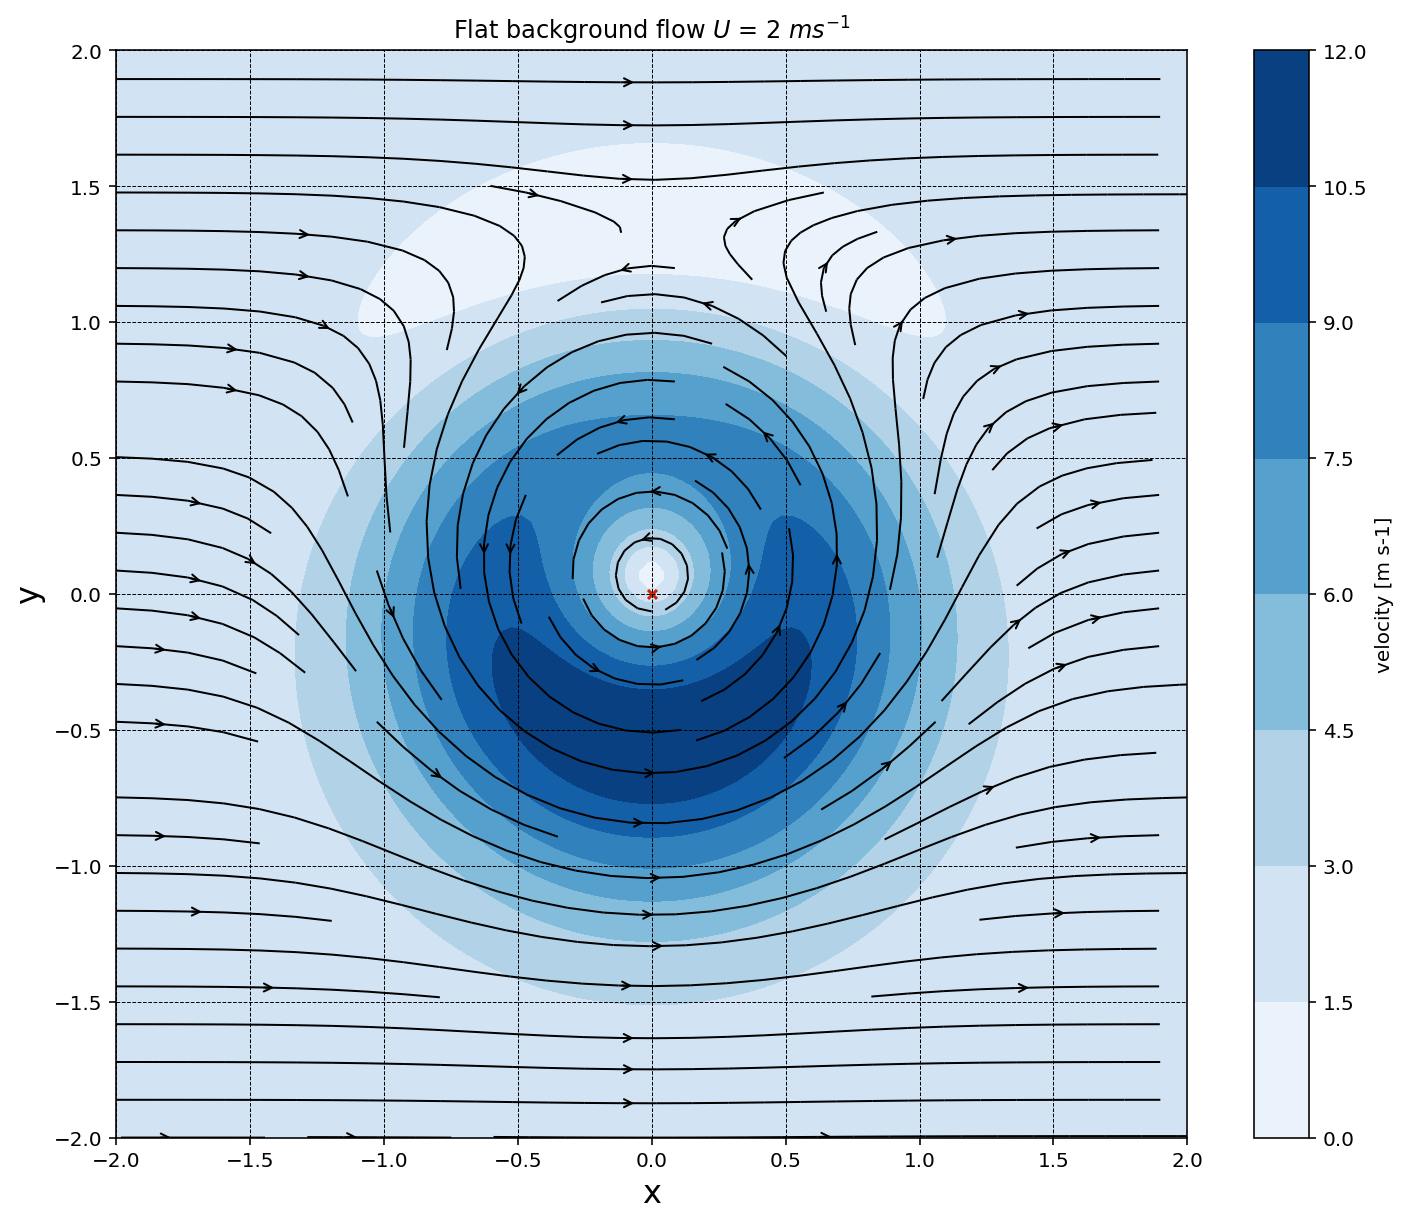

In [7]:
size=12

fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.grid(color='black', linestyle='--', linewidth=0.5)

# plt.title("Couette background flow $U_{max}$ = 5 $ms^{-1}$")
plt.title("Flat background flow $U$ = 2 $ms^{-1}$")


plt.contourf(X, Y, np.sqrt(u**2+v**2), cmap='Blues') # 20, vmin=0,vmax=13, 
cbar = plt.colorbar()
cbar.ax.set_ylabel('velocity [m s-1]')

plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
plt.show()

Vorticity

In [8]:
def vorticity(u,v,dx,dy):
    dudy = np.gradient(u, dy, axis=0)
    dvdx = np.gradient(v, dx, axis=1)
    return (dvdx-dudy)

In [194]:
eta = vorticity(u, v, 2000, 2000)

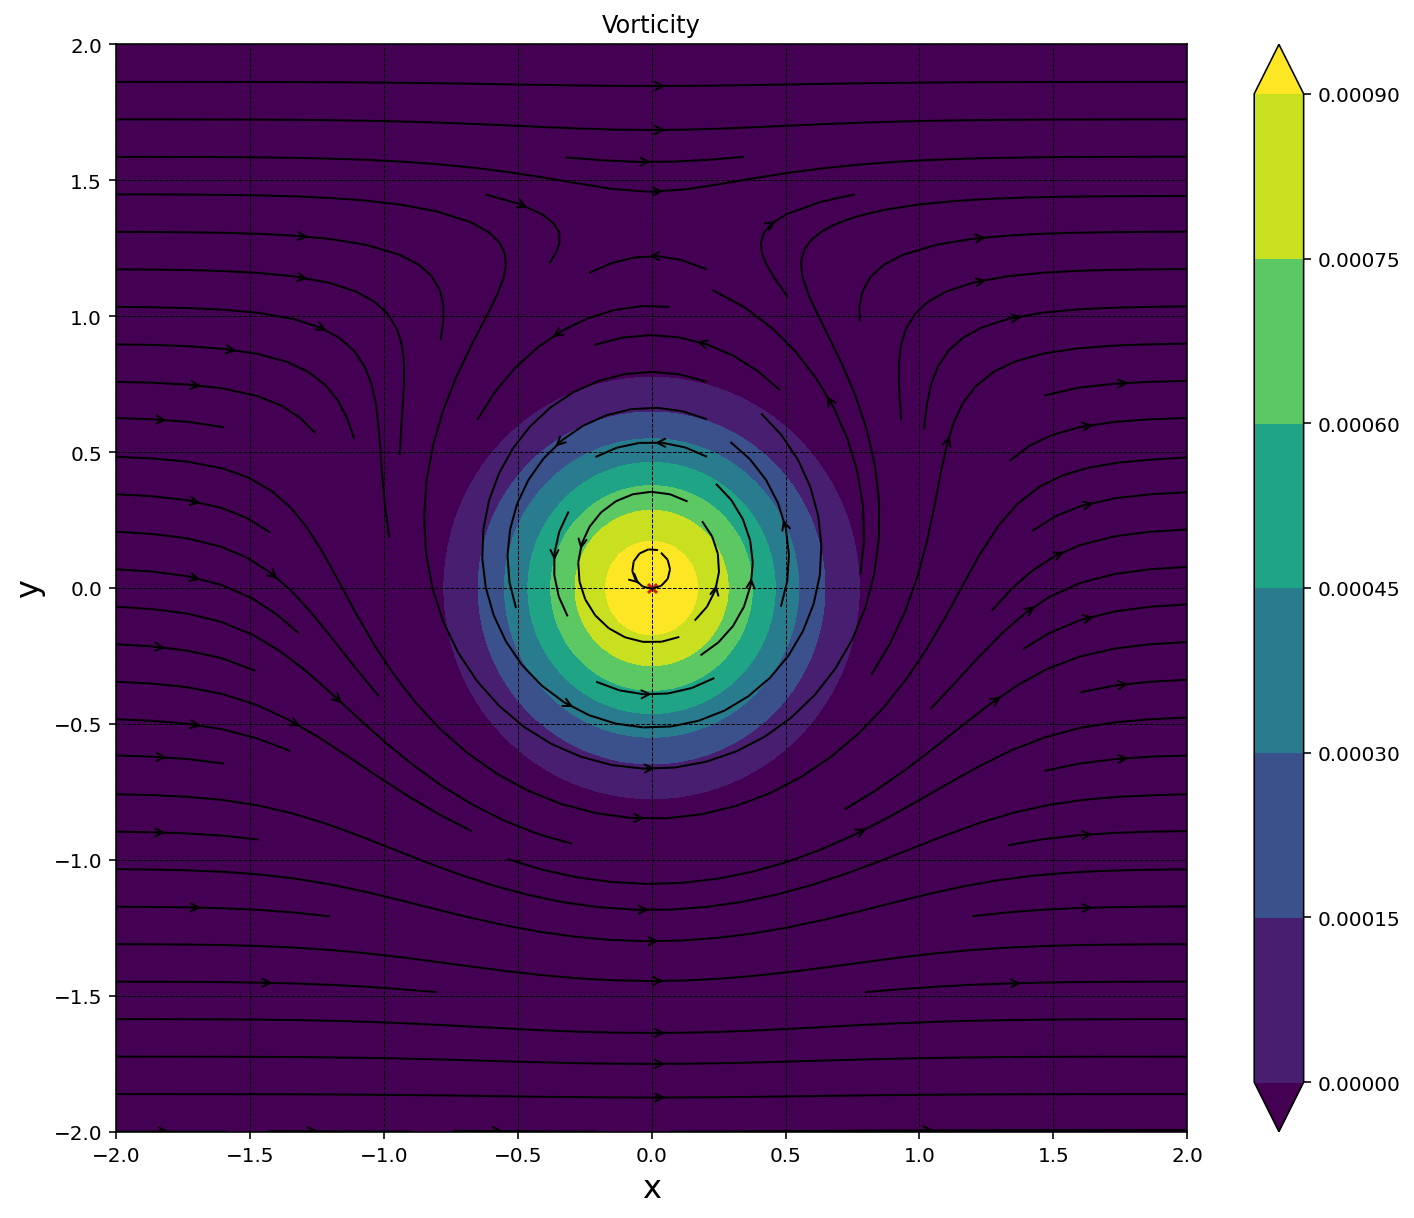

In [195]:
size=12

fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.grid(color='black', linestyle='--', linewidth=0.5)

plt.title("Vorticity")

plt.contourf(X, Y, eta, extend='both') # 20, vmin=0,vmax=13, 
plt.colorbar()
plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
plt.show()

Q criterion (2D)

In [211]:
def velocity_gradient_2d(u, v, dx, dy):
    dudx = np.gradient(u, dx, axis=1)
    dudy = np.gradient(u, dy, axis=0)
    dvdx = np.gradient(v, dx, axis=1)
    dvdy = np.gradient(v, dy, axis=0)
    
    velgrad = np.full((u.shape[0],u.shape[1],2,2),-999.)
    velgrad[:,:,0,0] = dudx
    velgrad[:,:,0,1] = dudy
    velgrad[:,:,1,0] = dvdx
    velgrad[:,:,1,1] = dvdy
    
    return velgrad

In [197]:
tgradv = velocity_gradient_2d(u, v, 20000, 20000)
tgradvt = np.swapaxes(tgradv,2,3)

In [198]:
omega = 0.5*(tgradv-tgradvt)
symmetric = 0.5*(tgradv+tgradvt)

In [199]:
omega_norm = np.linalg.norm(omega, axis=(2,3) )
symmetric_norm = np.linalg.norm(symmetric, axis=(2,3))

In [200]:
q = 0.5*( omega_norm**2 - symmetric_norm**2 )

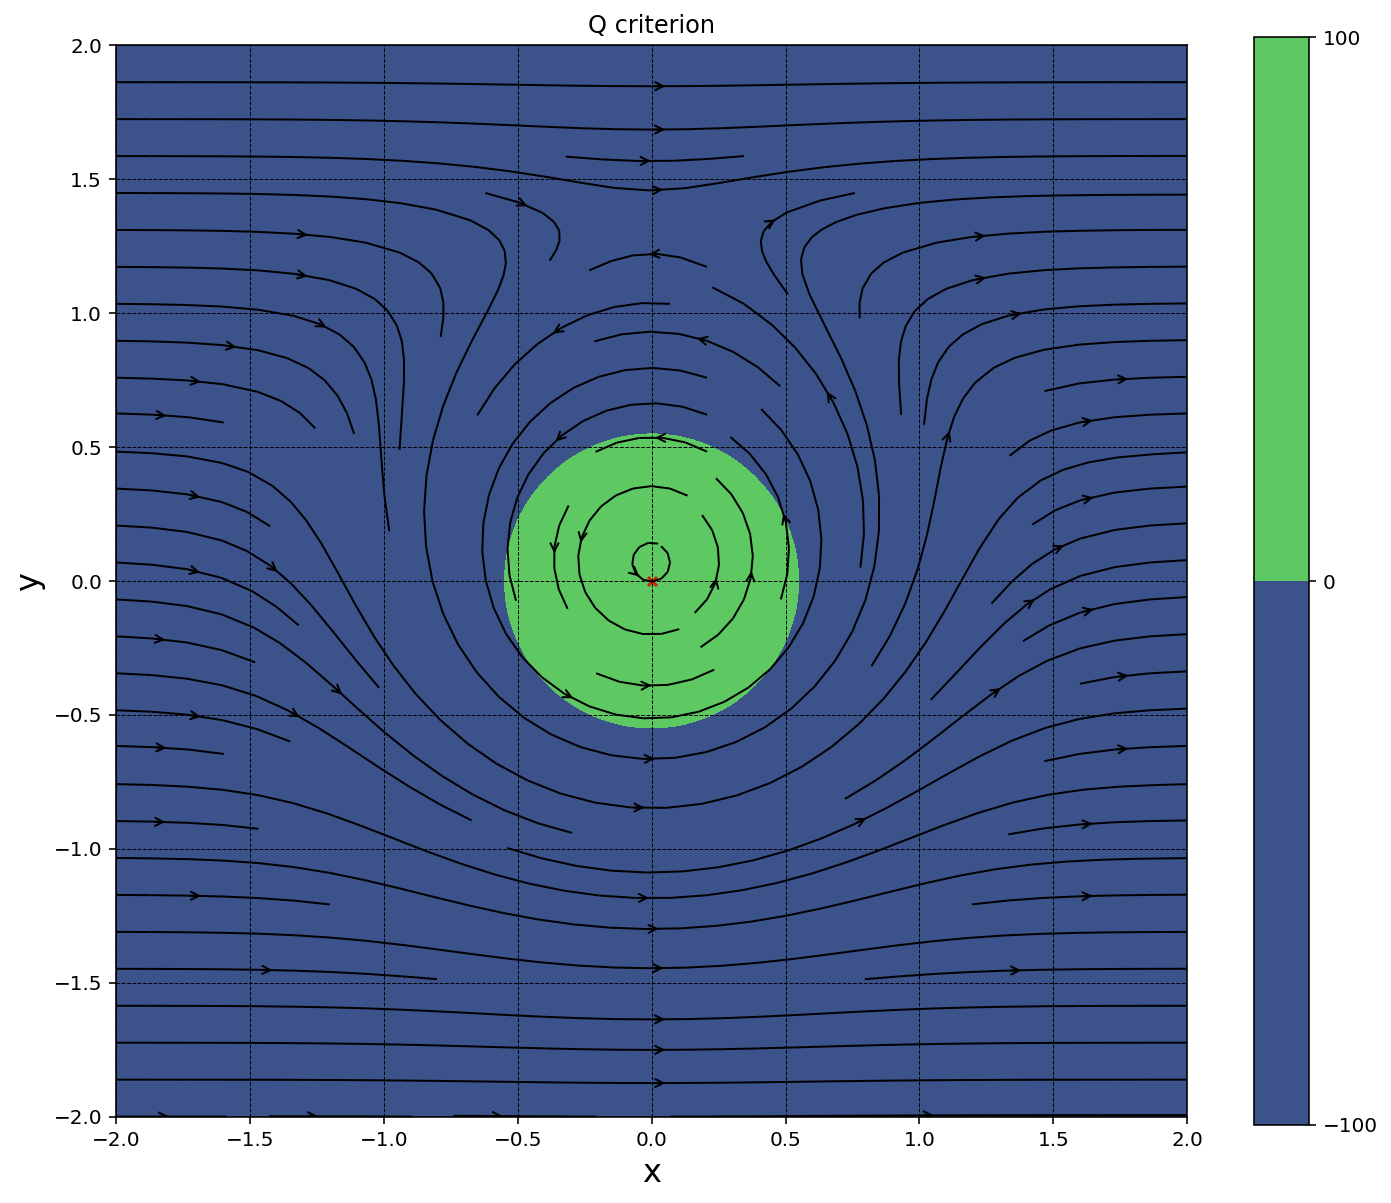

In [203]:
size=12

fig = plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size-2))
plt.gca().set_aspect("equal")
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.grid(color='black', linestyle='--', linewidth=0.5)

plt.title("Q criterion")

plt.contourf(X, Y, q, levels=[-100, 0.0, 100]) # 20, vmin=0,vmax=13, 
plt.colorbar()
plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
plt.scatter(center[0], center[1], color='#CD2305', s=20, marker='x')
plt.show()

Lambda2 criterion (2D)

The gradient velocity tensor $\mathbf{J}$:
\begin{equation*}
\mathbf{J} \equiv \Delta \vec{u} = \begin{vmatrix}
\frac{\partial u}{\partial x} &  \frac{\partial u}{\partial y} & \frac{\partial u}{\partial z} \\
\frac{\partial v}{\partial x} &  \frac{\partial v}{\partial y} & \frac{\partial v}{\partial z} \\
\frac{\partial w}{\partial x} &  \frac{\partial w}{\partial y} & \frac{\partial w}{\partial z} 
\end{vmatrix}
\end{equation*}
Where $\vec{u}$ is the velocity field. The gradient velocity tensor is then decomposed into its symmetric ($\mathbf{S}$) and antisymmetric ($\mathbf{\Omega}$) parts:
\begin{equation*}
\mathbf{S} = \frac{\mathbf{J}+\mathbf{J}^T}{2} \\
\mathbf{\Omega} = \frac{\mathbf{J}-\mathbf{J}^T}{2}
\end{equation*}
Next the three eigenvalues of $\mathbf{S}^2+\mathbf{\Omega}^2$ are calculated so that for each point in the velocity field $\vec{u}$ there are three corresponding eigenvalues: $\lambda_1, \lambda_2, \lambda_3$.  The eigenvalues are ordered in such a way that $\lambda_1 \geq \lambda_2 \geq \lambda_3$. A point in the velocity field is part of a vortex core only if at least two of its eigenvalues are negative i.e. if $\lambda_2 \lt 0$. This is what gave the Lambda2 method its name.

Src: https://en.wikipedia.org/wiki/Lambda2_method#cite_ref-2

In [ ]:
def lambda2(tgradv):
    dims = len(tgradv.shape)

    if dims == 4:
        dim1 = 2
        dim2 = 3
    else:
        dim1 = 3
        dim2 = 4

    tgradvt = np.swapaxes(tgradv, dim1, dim2)

    o2 = (0.5*(tgradv - tgradvt))**2
    s2 = (0.5*(tgradv + tgradvt))**2

    A = s2 + o2 

    L = la.eigvals(a)
